## Mounting Colab

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing libraries

In [26]:
!pip install ultralytics opencv-python

In [27]:
# Fix locale issue
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [28]:
!pip install deep-sort-realtime

## Importing Libraries

In [29]:
import os
import cv2
import math
import pickle
import random
import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
import tensorflow as tf
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LinearRegression
from collections import defaultdict, Counter, deque
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Input
from deep_sort_realtime.deepsort_tracker import DeepSort
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Loading model and dataset

In [30]:
base_dir = "/content/drive/MyDrive/GraduateProject"
dataset_path = os.path.join(base_dir, "dataset")
yaml_path = os.path.join(dataset_path, "data.yaml")
drive_project_path = os.path.join(base_dir, "YOLO_runs")
video_path = "/content/drive/MyDrive/GraduateProject/Test_clip.mp4"
model_path = "/content/drive/MyDrive/GraduateProject/YOLO_runs/player_detection/weights/best.pt"

## Function to convert pixels to meters dynamically from the input video

In [31]:
def calculate_pixels_to_meters(video_path, real_width_m=6.1, real_length_m=13.4):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if not ret or frame is None:
        raise ValueError(f"Could not read video from path: {video_path}. Check if the file exists and is a valid video.")

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

    if lines is None:
        raise Exception("Court lines not detected")

    x_coords, y_coords = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        x_coords += [x1, x2]
        y_coords += [y1, y2]

    pixel_width = max(x_coords) - min(x_coords)
    pixel_height = max(y_coords) - min(y_coords)

    scale_w = real_width_m / pixel_width
    scale_h = real_length_m / pixel_height
    return (scale_w + scale_h) / 2

## Player Tracking - DeepSORT

In [32]:
deepsort_output_path = "/content/drive/MyDrive/GraduateProject/deepsort_output.mp4"

PIXELS_TO_METERS = calculate_pixels_to_meters(video_path)

model = YOLO(model_path)
tracker = DeepSort(max_age=30, n_init=3)

cap = cv2.VideoCapture(video_path)
fps = 20
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
time_interval = 1 / fps

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(deepsort_output_path, fourcc, fps, (W, H))

positions = defaultdict(list)
metrics = defaultdict(lambda: {"distance": [], "speed": [], "acceleration": []})
bounding_boxes_per_frame = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)[0]
    detections = []

    for box in results.boxes.data.cpu().numpy():
        x1, y1, x2, y2, conf, cls = box
        if conf > 0.5:
            detections.append(([x1, y1, x2 - x1, y2 - y1], conf, int(cls)))

    tracks = tracker.update_tracks(detections, frame=frame)
    tracked_this_frame = {}

    for track in tracks:
        if not track.is_confirmed():
            continue

        tid = int(track.track_id)
        x1, y1, x2, y2 = map(int, track.to_ltrb())
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)

        positions[tid].append((cx, cy))
        tracked_this_frame[tid] = (x1, y1, x2, y2)

        if len(positions[tid]) > 1:
            d = math.hypot(cx - positions[tid][-2][0], cy - positions[tid][-2][1]) * PIXELS_TO_METERS
            v = d / time_interval
            metrics[tid]["distance"].append(d)
            metrics[tid]["speed"].append(v)
            if len(metrics[tid]["speed"]) > 1:
                a = (metrics[tid]["speed"][-1] - metrics[tid]["speed"][-2]) / time_interval
                metrics[tid]["acceleration"].append(a)

        # Draw box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"ID:{tid}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    bounding_boxes_per_frame.append(tracked_this_frame)
    out.write(frame)

cap.release()
out.release()


0: 384x640 1 player1, 1 player2, 115.4ms
Speed: 4.6ms preprocess, 115.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player1, 1 player2, 97.5ms
Speed: 2.5ms preprocess, 97.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player1, 1 player2, 87.2ms
Speed: 2.2ms preprocess, 87.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player1, 1 player2, 84.2ms
Speed: 2.4ms preprocess, 84.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player1, 1 player2, 99.0ms
Speed: 2.5ms preprocess, 99.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player1, 1 player2, 95.8ms
Speed: 3.5ms preprocess, 95.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player1, 1 player2, 108.9ms
Speed: 2.5ms preprocess, 108.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player1, 1 playe

In [33]:
# Creation of pickel file consiting of positions, metrics, and bounding boxes

# Classify 1 and 2
court_mid_x = W // 2
left_ids, right_ids = [], []

for tid, pts in positions.items():
    if len(pts) < 5:
        continue
    avg_x = np.mean([x for x, _ in pts])
    (left_ids if avg_x < court_mid_x else right_ids).append(tid)

merged_positions = {"Player 1": [], "Player 2": []}
merged_metrics = {
    "Player 1": {"distance": [], "speed": [], "acceleration": []},
    "Player 2": {"distance": [], "speed": [], "acceleration": []}
}
id_map = {}

if len(left_ids) + len(right_ids) <= 2:
    sorted_ids = sorted(positions.items(), key=lambda x: len(x[1]), reverse=True)[:2]
    for i, (tid, pts) in enumerate(sorted_ids):
        player = f"Player {i+1}"
        merged_positions[player] = pts
        id_map[tid] = player
        for key in merged_metrics[player]:
            merged_metrics[player][key] = metrics[tid][key]
else:
    for tid in left_ids:
        merged_positions["Player 1"].extend(positions[tid])
        id_map[tid] = "Player 1"
        for key in merged_metrics["Player 1"]:
            merged_metrics["Player 1"][key].extend(metrics[tid][key])
    for tid in right_ids:
        merged_positions["Player 2"].extend(positions[tid])
        id_map[tid] = "Player 2"
        for key in merged_metrics["Player 2"]:
            merged_metrics["Player 2"][key].extend(metrics[tid][key])

# saving into file
data_output_path = "/content/drive/MyDrive/GraduateProject/player_data.pkl"
os.makedirs(os.path.dirname(data_output_path), exist_ok=True)

with open(data_output_path, "wb") as f:
    pickle.dump({
        "positions": merged_positions,
        "metrics": merged_metrics,
        "bounding_boxes": bounding_boxes_per_frame
    }, f)

## Movement Analysis

Distance Travelled (in meters):
Player 1: 24.25 meters
Player 2: 26.89 meters


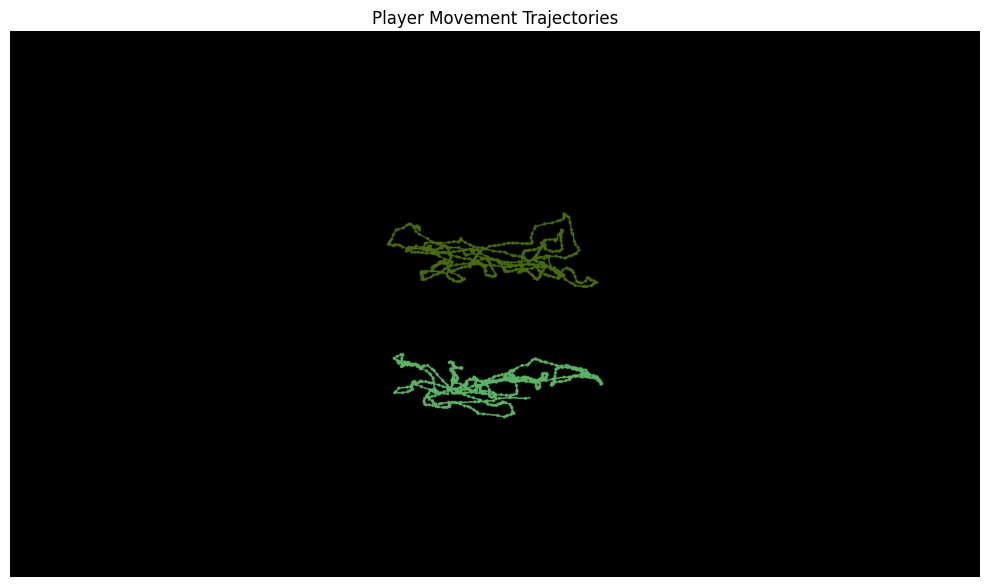

In [34]:
output_analysis_path = "/content/drive/MyDrive/GraduateProject/player_movement_analysis.png"
# load player data
with open(data_output_path, "rb") as f:
    data = pickle.load(f)

positions = data["positions"]

# load video to get frame dimensions
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if not ret:
    raise ValueError("Could not read frame from video.")

frame_height, frame_width = frame.shape[:2]

PIXELS_TO_METERS = calculate_pixels_to_meters(video_path)

# creating a blank trajectory images
trajectory_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)

# plot trajectory
for player_label, points in positions.items():
    color = tuple(np.random.randint(0, 255, size=3).tolist())
    for i in range(1, len(points)):
        cv2.line(trajectory_frame, points[i - 1], points[i], color, 2)
        cv2.circle(trajectory_frame, points[i], 3, color, -1)

# function to calculate distance
def calculate_distance(pts):
    return sum(
        math.hypot(pts[i][0] - pts[i - 1][0], pts[i][1] - pts[i - 1][1])
        for i in range(1, len(pts))
    ) * PIXELS_TO_METERS

print("Distance Travelled (in meters):")
for player_label, pts in positions.items():
    total_dist = calculate_distance(pts)
    print(f"{player_label}: {total_dist:.2f} meters")

# saving trajectory images
cv2.imwrite(output_analysis_path, trajectory_frame)

# display the graph
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(trajectory_frame, cv2.COLOR_BGR2RGB))
plt.title("Player Movement Trajectories")
plt.axis("off")
plt.tight_layout()
plt.show()

**Black background:** A blank canvas.

Two distinct colored paths: Each color represents a different player's movement trajectory:

One path is pink – Player 1.

The other is red – likely Player 2.

**Dots and lines:**

Dots represent player positions at each frame.

Lines connect the dots to illustrate movement over time.

### Burst Timeline

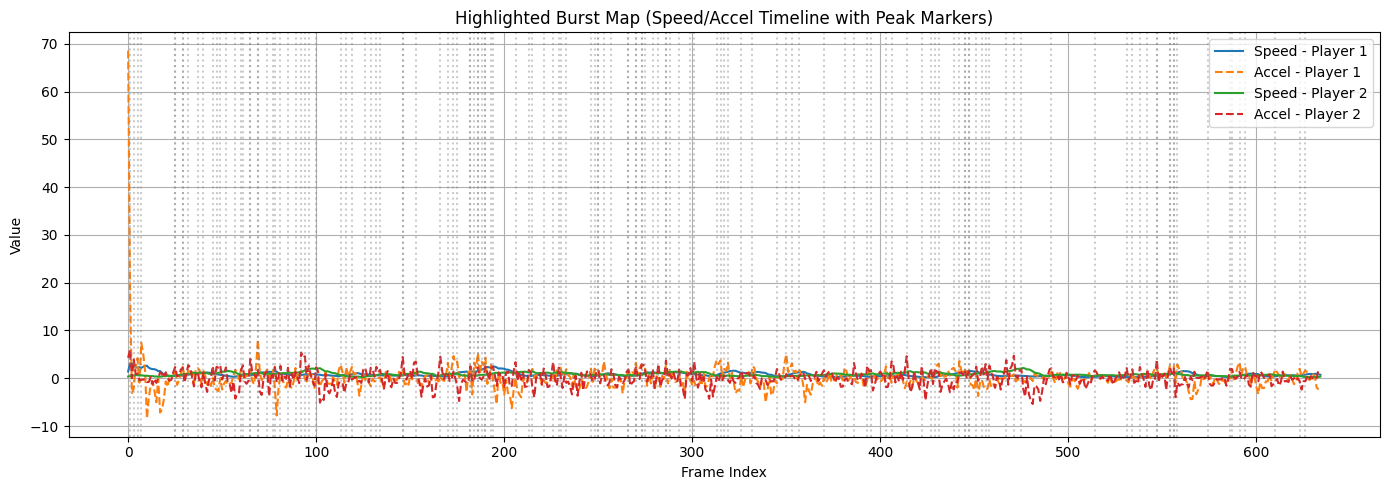

In [35]:
metrics = data["metrics"]

# Plot Burst Timeline
plt.figure(figsize=(14, 5))
zone_labels = ["Net", "Mid", "Back"]

for player_label in ["Player 1", "Player 2"]:
    speed_series = pd.Series(metrics[player_label]["speed"]).rolling(window=10, min_periods=1).mean()
    accel_series = pd.Series(metrics[player_label]["acceleration"]).rolling(window=10, min_periods=1).mean()

    if len(speed_series) == 0 or len(accel_series) == 0:
        print(f"No data for {player_label}. Skipping.")
        continue

    # Plot speed and acceleration
    plt.plot(speed_series, label=f"Speed - {player_label}")
    plt.plot(accel_series, linestyle='--', label=f"Accel - {player_label}")

    # Detect acceleration bursts (peaks)
    try:
        peaks, _ = find_peaks(accel_series, height=np.percentile(accel_series.dropna(), 85))
        for peak in peaks:
            plt.axvline(x=peak, linestyle=':', color='gray', alpha=0.4)
    except Exception as e:
        print(f"Could not find peaks for {player_label}: {e}")


plt.title("Highlighted Burst Map (Speed/Accel Timeline with Peak Markers)")
plt.xlabel("Frame Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()

burst_map_path = "/content/drive/MyDrive/GraduateProject/highlighted_bursts.png"
plt.savefig(burst_map_path, dpi=300)
plt.show()

**Player 1 (Blue - Speed, Orange Dashed - Acceleration)**

**Key Observations:**

1. **Large Acceleration Spikes at the Start:** The orange acceleration line peaks sharply near the beginning (especially in the first 10–20 frames), with values as high as 70. This likely corresponds to an explosive start—perhaps a powerful smash recovery or a net rush.

2. **Frequent High Bursts:** Many vertical dotted lines are concentrated throughout the early and middle segments of the timeline, especially around frame indices 0–150, 200–300, and again between 400–500. These indicate repeated bursts of explosive motion.

3. **Speed Trend (Blue Line):** Generally moderate, with visible fluctuations. This suggests periods of rapid deceleration after acceleration bursts, common during chase-downs or mid-rally shifts in tempo.

**Tactical Insight:**
1. **Explosive & Aggressive:** Player 1 exhibits a burst-heavy style—likely performing quick transitions, lunges, and reactive sprints during pressure situations.

2. **Rally Breaker:** The pattern suggests short, high-intensity movements followed by stabilization—possibly trying to disrupt rhythm or seize control points mid-rally.

3. **Conditioning Focus:** Frequent bursts might lead to fatigue later in a match. May benefit from more energy-efficient play in longer matches.

**Player 2 (Green - Speed, Red Dashed - Acceleration)**

**Key Observations:**

1. **Moderate Acceleration Peaks:** The red acceleration line is steadier, with smaller and more evenly spaced peaks throughout the frame timeline. There are no extreme spikes like Player 1, indicating more measured bursts.

2. **Even Burst Distribution:** Vertical markers appear across the entire timeline, particularly between frames 100–300 and again around 500–600, showing consistent energy usage across the game.

3. **Speed Curve (Green Line):** Smoother and flatter than Player 1’s, which implies Player 2 maintains a controlled pace with less dramatic changes in movement intensity.

**Tactical Insight:**
1. **Tempo Controller:** Player 2 seems to favor energy-efficient positioning and minimizes unnecessary motion—possibly playing with better anticipation and court control.

2. **Baseline Stability:** Their movement pattern could reflect a defensive or counterattacking strategy—waiting for the opponent to make mistakes rather than forcing errors.

3. **Endurance Oriented:** The smooth pacing could make them more suited for long rallies, especially in extended sets or tournament play.

**Overall Match Dynamics (from Burst Map):**

**Clash of Styles:**The contrast suggests a potential matchup between a power-oriented attacker (Player 1) and a strategic stabilizer (Player 2).

**Burst Density vs. Efficiency:** While Player 1 triggers more high-energy moments (bursts), Player 2 manages a lower variance approach with sustained tempo and positional discipline.

### Heatmap

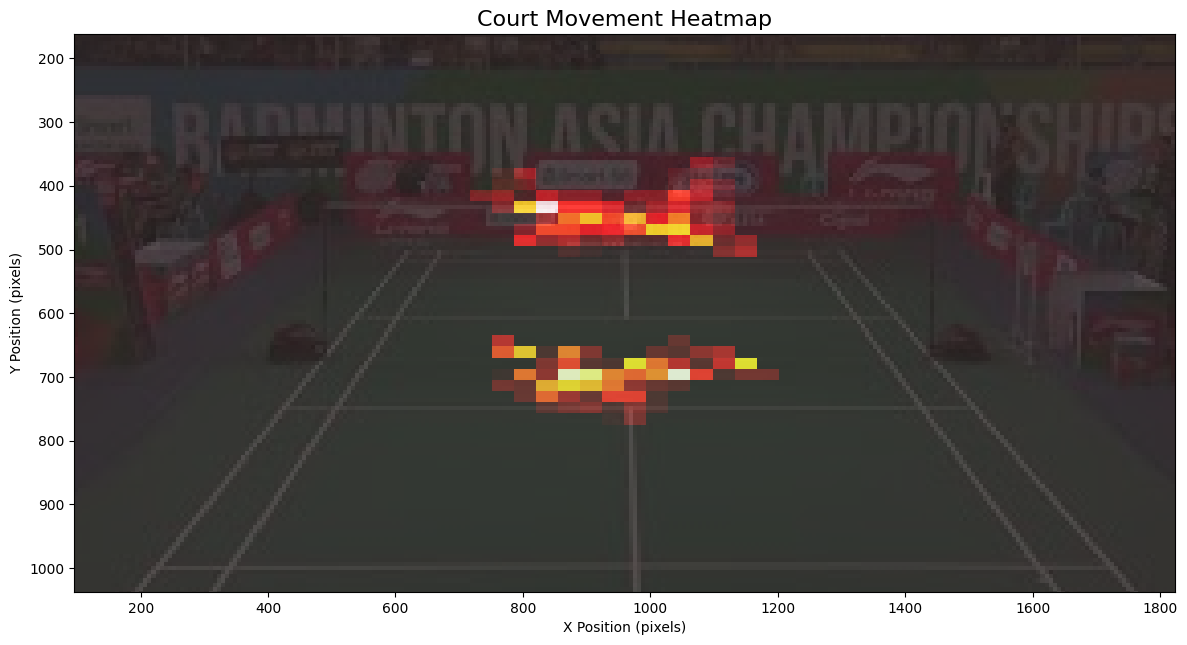

In [36]:
save_path =  "/content/drive/MyDrive/GraduateProject/heatmap.png"
court_img_path = "/content/drive/MyDrive/GraduateProject/court.jpeg"
all_points = np.array([pt for pts in positions.values() for pt in pts])

video_height, video_width = frame.shape[:2]

# Load court image
court_img = plt.imread(court_img_path)

# Dynamically set court bounds based on frame size
x_margin = int(video_width * 0.05)
y_margin_top = int(video_height * 0.15)
y_margin_bottom = int(video_height * 0.04)

court_x_min = x_margin
court_x_max = video_width - x_margin
court_y_min = y_margin_top
court_y_max = video_height - y_margin_bottom

# Filter valid points
court_only_points = np.array([
    [x, y] for x, y in all_points
    if court_x_min <= x <= court_x_max and court_y_min <= y <= court_y_max
]).reshape(-1, 2)


if court_only_points.shape[0] == 0:
    print(" No valid court points found inside court bounds.")
else:
    heatmap, _, _ = np.histogram2d(
        court_only_points[:, 1], court_only_points[:, 0],
        bins=[50, 50],
        range=[[court_y_min, court_y_max], [court_x_min, court_x_max]]
    )

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(court_img, extent=[0, video_width, video_height, 0], alpha=0.6)
    ax.imshow(
        heatmap, cmap='hot', interpolation='nearest', alpha=0.7,
        extent=[court_x_min, court_x_max, court_y_max, court_y_min]
    )
    ax.set_title("Court Movement Heatmap", fontsize=16)
    ax.set_xlabel("X Position (pixels)")
    ax.set_ylabel("Y Position (pixels)")
    ax.grid(False)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

This heatmap provides a **spatial overview of player movement frequency** across the badminton court. **Warmer regions (yellow/red)** indicate areas with **higher foot traffic or player presence**, while **darker regions (black/gray)** indicate **less activity**. It shows two separate activity clusters — one on each half of the court. This strongly suggests the successful tracking of both players in their respective zones.

### Convex Hull

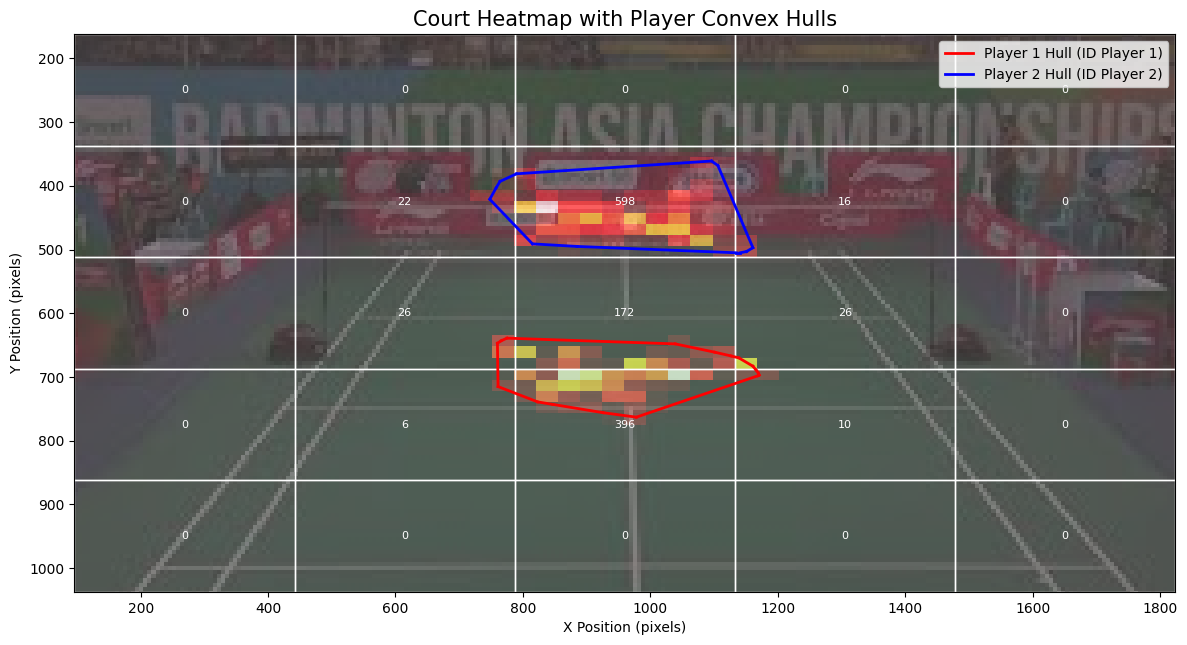


Player Spatial Spread Analysis (Convex Hull Area):
Player 1 → Area: 2.78 m²
Player 2 → Area: 2.19 m²
Player 1 covers more ground (spatial dominance).


In [37]:
save_path = "/content/drive/MyDrive/GraduateProject/court_usage_per_player_hull_grid.png"
# Convex Hull Calculation Per Player
hull_areas = {}
court_filtered_points = {}

for pid, pts in positions.items():
    pts = np.array(pts)
    court_only = np.array([
        [x, y] for x, y in pts
        if court_x_min <= x <= court_x_max and court_y_min <= y <= court_y_max
    ])
    court_filtered_points[pid] = court_only
    if len(court_only) >= 3:
        try:
            hull = ConvexHull(court_only)
            hull_areas[pid] = hull.volume * (PIXELS_TO_METERS ** 2)
        except:
            hull_areas[pid] = 0
    else:
        hull_areas[pid] = 0

# Plot Heatmap, Convex Hulls, Grid
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(court_img, extent=[0, video_width, video_height, 0], alpha=0.6)

colors = ['red', 'blue', 'green', 'purple']
for i, (pid, pts) in enumerate(court_filtered_points.items()):
    if len(pts) >= 3:
        try:
            hull = ConvexHull(pts)
            color = colors[i % len(colors)]
            label = f"Player {i+1} Hull (ID {pid})"
            for j, simplex in enumerate(hull.simplices):
                ax.plot(pts[simplex, 0], pts[simplex, 1], color=color, linewidth=2,
                        label=label if j == 0 else None)  # Only label the first line
        except:
            continue

# Heatmap
all_points = np.concatenate([v for v in court_filtered_points.values() if len(v) > 0], axis=0)
heatmap, _, _ = np.histogram2d(
    all_points[:, 1], all_points[:, 0],
    bins=50,
    range=[[court_y_min, court_y_max], [court_x_min, court_x_max]]
)
ax.imshow(
    heatmap, cmap='hot', interpolation='nearest', alpha=0.5,
    extent=[court_x_min, court_x_max, court_y_max, court_y_min]
)

# Spatial Grid Overlay
grid_rows, grid_cols = 5, 5
x_step = (court_x_max - court_x_min) / grid_cols
y_step = (court_y_max - court_y_min) / grid_rows

for i in range(grid_rows):
    for j in range(grid_cols):
        left = court_x_min + j * x_step
        top = court_y_min + i * y_step
        count = np.sum(
            (all_points[:, 0] >= left) & (all_points[:, 0] < left + x_step) &
            (all_points[:, 1] >= top) & (all_points[:, 1] < top + y_step)
        )
        rect = patches.Rectangle((left, top), x_step, y_step,
                                 linewidth=1, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
        ax.text(left + x_step / 2, top + y_step / 2, str(int(count)),
                color='white', ha='center', va='center', fontsize=8)

# Final Plot Settings
ax.set_title("Court Heatmap with Player Convex Hulls", fontsize=15)
ax.set_xlabel("X Position (pixels)")
ax.set_ylabel("Y Position (pixels)")

# Deduplicate legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper right')

ax.grid(False)
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print("\nPlayer Spatial Spread Analysis (Convex Hull Area):")
sorted_areas = sorted(hull_areas.items(), key=lambda x: x[1], reverse=True)
for i, (pid, area) in enumerate(sorted_areas, 1):
    print(f"Player {i} → Area: {area:.2f} m²")

if len(sorted_areas) >= 2:
    if sorted_areas[0][1] > sorted_areas[1][1]:
        print("Player 1 covers more ground (spatial dominance).")
    elif sorted_areas[0][1] < sorted_areas[1][1]:
        print("Player 2 covers more ground (spatial dominance).")
    else:
        print("Both players have similar spatial coverage.")

This image is a tactical heatmap overlaid with:

* Convex hulls showing outer boundary of a player coverage zones. A convex hull is the **smallest possible polygon** that encloses all position points of a player. It’s like stretching a rubber band around all the places the player reached on court.


* Heatmap indicating where players spent the most time.This shows positional intensity: where players spent the most time.

* Grid zones with counts (number of frames or presence) indicating spatial dominance and movement density.Each cell shows how many times (frames or positions) players were present in that area.



**Convex Hull**

**Player 1 (Red Hull)** has a larger convex hull, stretching across a broader area of the court.
**Player 2 (Blue Hull)** has a more compact and tighter boundary, mostly centered around the midcourt and front zones.

**Insights:**
    
* Player 1 shows signs of higher mobility, likely covering deeper court zones—possibly reacting to opponent’s attacking shots like smashes or clears.

* Player 2 appears to operate within a defined tactical comfort zone, indicating control play, net dominance, or waiting to counter from midcourt.


**Heatmap**

Heat intensity corresponds to time spent in that area — red = more time.

* Player 1’s heat shows high intensity in deep mid-right backcourt, indicating retrievals and defensive stances.Spread suggests baseline defense and readiness for long rallies.

* Player 2’s heat is concentrated in center-midcourt, signaling a stationary or central control approach. Less time spent in backcourt implies fewer full-court movements.

This reinforces the hull observation — Player 1 was more reactive, while Player 2 maintained control from a central position.


**Spatial Grid with Counts**.

This tells us the core zones of each player:

* Player 1: Defensive backcourt & mid-right zone coverage.

* Player 2: Midcourt-centered control, lower spatial spread.

## Tactical Analysis

### Zone Analysis - K-Means Clustering

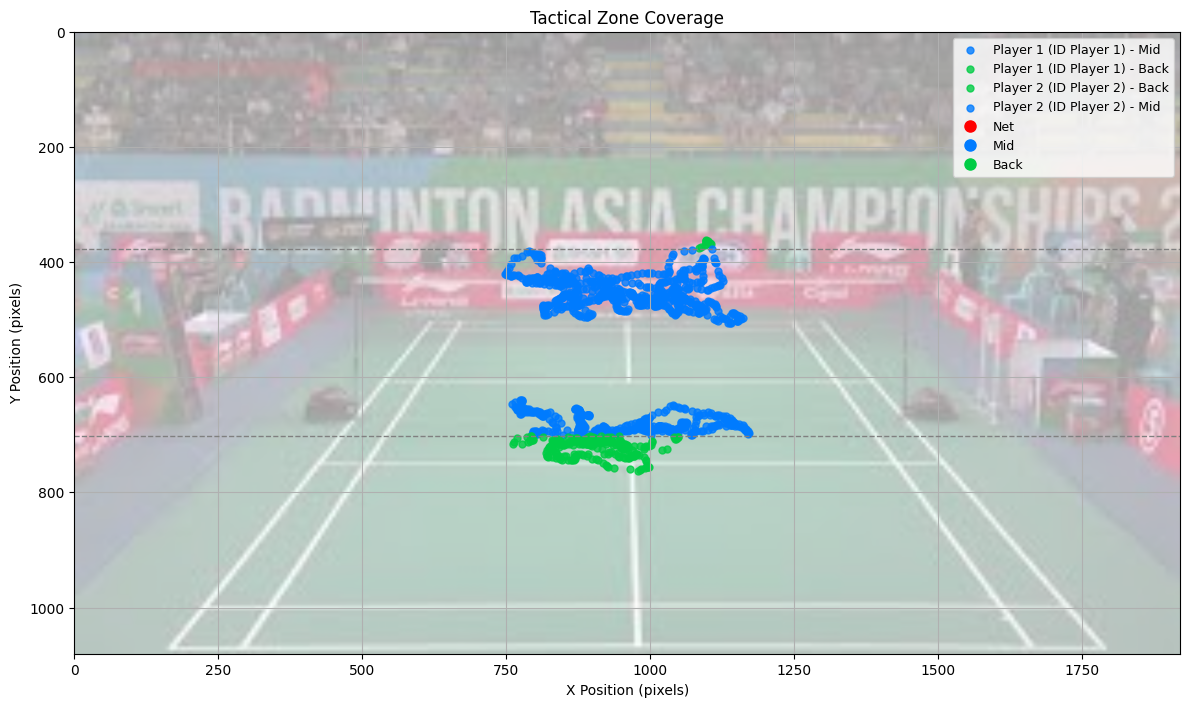


Zone Summary:
  Player ID  Zone     Time %
0  Player 1  Back  34.748428
1  Player 1   Mid  65.251572
2  Player 2  Back   1.729560
3  Player 2   Mid  98.270440


In [38]:
H, W = frame.shape[:2]
court_img = plt.imread(court_img_path)
court_img = cv2.resize(court_img, (W, H))

plot_path = "/content/drive/MyDrive/GraduateProject/final_zone_plot.png"
csv_path = "/content/drive/MyDrive/GraduateProject/final_zone_report.csv"

net_y = H // 2
zone_thresholds = [net_y - H * 0.15, net_y + H * 0.15]  # Mid-centered thresholds
zone_colors = {'Net': '#FF0000', 'Mid': '#007BFF', 'Back': '#00CC44'}

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(court_img, extent=[0, W, H, 0], alpha=0.4)

csv_data = []
used_labels = set()

for i, (pid, pts) in enumerate(positions.items()):
    if len(pts) == 0:
        continue

    pts_array = np.array(pts)
    y_coords = pts_array[:, 1]
    avg_y = np.mean(y_coords)

    # Flip zones for players on opposite sides of court
    if avg_y < net_y:
        zone_labels = ["Back", "Mid", "Net"]
    else:
        zone_labels = ["Net", "Mid", "Back"]

    zone_indices = np.digitize(y_coords, bins=zone_thresholds)
    zone_indices = np.clip(zone_indices, 0, 2)  # 3 zones max
    label_per_point = [zone_labels[z] for z in zone_indices]

    zone_counter = Counter(label_per_point)
    total_pts = len(label_per_point)

    for zone in zone_labels:
        mask = np.array(label_per_point) == zone
        zone_pts = pts_array[mask]
        if len(zone_pts) == 0:
            continue

        percent = (zone_counter[zone] / total_pts) * 100
        csv_data.append({
            "Player ID": pid,
            "Zone": zone,
            "Time %": percent
        })

        label = f"Player {i+1} (ID {pid}) - {zone}"
        if label not in used_labels:
            used_labels.add(label)
            ax.scatter(zone_pts[:, 0], zone_pts[:, 1],
                       s=25, alpha=0.8, color=zone_colors[zone],
                       label=label)

# Net zone boundaries
for y in zone_thresholds:
    ax.axhline(y, color='gray', linestyle='--', linewidth=1)

# Always show all zone colors in legend
zone_labels_all = ["Net", "Mid", "Back"]
dummy_legend = [mlines.Line2D([], [], color=zone_colors[z], marker='o', linestyle='None',
                               markersize=8, label=z) for z in zone_labels_all]

#  Deduplicate + Append dummy legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(list(unique.values()) + dummy_legend,
          list(unique.keys()) + zone_labels_all,
          loc='upper right', fontsize=9)

# plot
ax.set_title("Tactical Zone Coverage")
ax.set_xlabel("X Position (pixels)")
ax.set_ylabel("Y Position (pixels)")
ax.grid(True)

plt.tight_layout()
plt.savefig(plot_path, dpi=300)
pd.DataFrame(csv_data).sort_values(["Player ID", "Zone"]).to_csv(csv_path, index=False)
plt.show()

print("\nZone Summary:")
print(pd.read_csv(csv_path))

**This plot visualizes the zones each player occupies on the court:**

* Points are split by tactical zones: Back, Mid, and Net.

* Each point represents the player's location at a specific time.

**The court is divided horizontally (by Y position) into:**

* Net Zone — closest to the net

* Midcourt Zone — center of the court

* Backcourt Zone — farthest from the net

**Player 1 (Green & Blue Dots)**

Zones Covered: Midcourt (blue) and Backcourt (green)

**Distribution Insight:**

* Strong presence in both midcourt and deep backcourt zones.

* The coverage pattern suggests that Player 1 is highly mobile, moving across multiple tactical regions.

* No presence detected in the net zone, implying a defensive or reactive role.

**Tactical Interpretation:**

* Likely played a retrieving style, staying deep and reacting to shots from the opponent.

* Possibly used smashes or clears from the backcourt, then repositioned to midcourt to reset.

* Might be responding to an attacking or control-heavy opponent.


**Player 2 (Only Blue Points)**
Zones Covered: Exclusively midcourt

**Distribution Insight:**

* Confined to a tighter, compact area — shows no movement into backcourt or net zones.

* Points are densely clustered near the T-junction (intersection of center and service lines).

**Tactical Interpretation:**

* Likely employed a control-oriented strategy, staying central to cover quick responses.

* May be trying to dictate the rally pace, forcing the opponent to move more.

* Could imply shorter rallies, or Player 2 played fewer full-length court exchanges.

* May also hint at positional anticipation rather than movement-based strategy.

### Bar chart - Tactical Zone Comparison

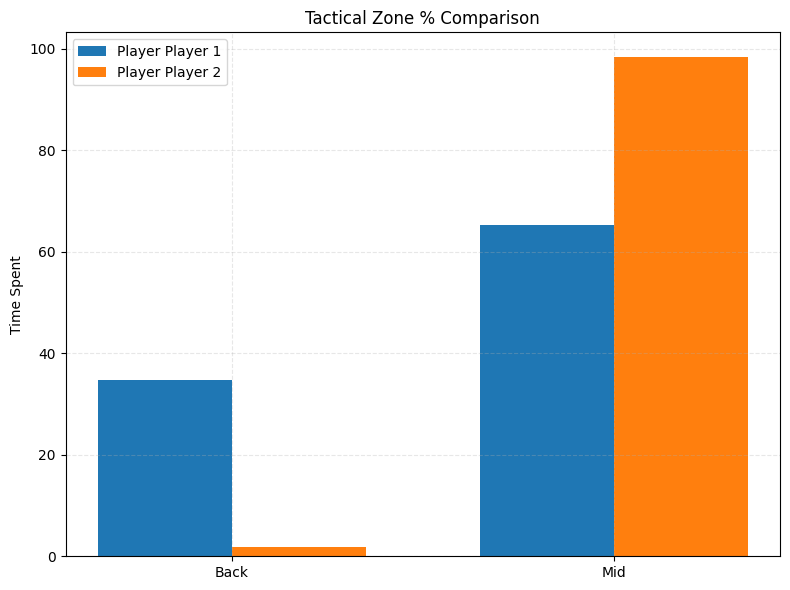

In [39]:
csv_path = "/content/drive/MyDrive/GraduateProject/final_zone_report.csv"
df = pd.read_csv(csv_path)

#  Pivot the data: Zones as rows, Players as columns
pivot_df = df.pivot(index='Zone', columns='Player ID', values='Time %')
pivot_df = pivot_df.fillna(0).sort_index()  # in case any zone is missing

# plot setup
fig, ax = plt.subplots(figsize=(8, 6))

zones = pivot_df.index
x = range(len(zones))
bar_width = 0.35

# Player IDs
players = pivot_df.columns.tolist()

# Bar chart
ax.bar([i - bar_width/2 for i in x], pivot_df[players[0]], width=bar_width, label=f'Player {players[0]}')
ax.bar([i + bar_width/2 for i in x], pivot_df[players[1]], width=bar_width, label=f'Player {players[1]}')

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(zones)
ax.set_ylabel("Time Spent")
ax.set_title("Tactical Zone % Comparison")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

bar_chart_path = "/content/drive/MyDrive/GraduateProject/zone_comparison_bar_chart.png"
plt.tight_layout()
plt.savefig(bar_chart_path, dpi=300)
plt.show()

### LSTM - for zone prediction

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6305 - loss: 0.8291 - val_accuracy: 0.8840 - val_loss: 0.4174
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8824 - loss: 0.4088 - val_accuracy: 0.8840 - val_loss: 0.3747
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8824 - loss: 0.3712 - val_accuracy: 0.8840 - val_loss: 0.3686
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8824 - loss: 0.3639 - val_accuracy: 0.8840 - val_loss: 0.3663
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8824 - loss: 0.3598 - val_accuracy: 0.8840 - val_loss: 0.3652
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8824 - loss: 0.3561 - val_accuracy: 0.8840 - val_loss: 0.3645
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8824 - loss: 0.3522 - val_accuracy: 0.8840 - val_loss: 0.3637
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8824 - loss: 0.3477 - val_accuracy: 0.8840 - val_loss

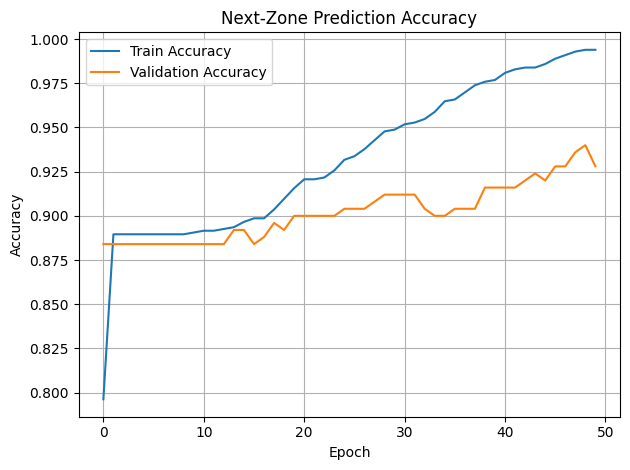

Final Validation Accuracy: 0.93


In [40]:
# Set random seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)
plot_save_path = "/content/drive/MyDrive/GraduateProject/next-zone_prediction_accuracy.png"
video_height = frame.shape[0]

# Zone assignment
zone_labels = ["Net", "Mid", "Back"]
zone_thresholds = [video_height * 0.33, video_height * 0.66]

player_zones = {}
for pid, pts in positions.items():
    y_coords = np.array([y for (_, y) in pts])
    zone_indices = np.digitize(y_coords, bins=zone_thresholds)
    zone_indices = np.clip(zone_indices, 0, 2)  # Ensure values are 0,1,2
    player_zones[pid] = zone_indices

# Prepare sequences
sequence_len = 10
X, y, player_ids = [], [], []

for pid in positions:
    if pid not in metrics:
        continue

    zone_seq = player_zones[pid]
    speed_seq = metrics[pid]["speed"]
    accel_seq = metrics[pid]["acceleration"]

    min_len = min(len(zone_seq), len(speed_seq), len(accel_seq))
    if min_len <= sequence_len:
        continue

    zone_seq = zone_seq[:min_len]
    speed_seq = speed_seq[:min_len]
    accel_seq = accel_seq[:min_len]

    for i in range(sequence_len, min_len - 1):
        seq_input = np.column_stack([
            speed_seq[i-sequence_len:i],
            accel_seq[i-sequence_len:i]
        ])
        X.append(seq_input)
        y.append(zone_seq[i])
        player_ids.append(pid)

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y, num_classes=3)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Input(shape=(sequence_len, 2)),
    LSTM(64),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

# Plot the graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Next-Zone Prediction Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(plot_save_path, dpi=300)
plt.show()

# print final accuracy
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {val_acc:.2f}")

This graph shows how well the LSTM model can predict a player’s next tactical zone — Net, Mid, or Back — based on their movement metrics like speed and acceleration over the last few frames.

**X-Axis:**

**Epoch:** Number of training cycles (from 1 to 50). Each epoch means the model has seen the entire training data once.

**Y-Axis:**

**Accuracy:** Ranges from 0 to 1 (or 0% to 100%) — it shows how well the model is correctly predicting the next zone.

**Blue Line:** Train Accuracy

* Shows how well the model is learning from the training data.

* Starts from around 0.79, quickly improves, and stabilizes close to 0.99.

* This shows that the model has effectively learned the patterns from historical player movement.

**Orange Line:** Validation Accuracy

* Measures how the model performs on unseen data.

* Starts at 0.89 and rises steadily to around 0.93–0.94.

* Suggests good generalization without overfitting.

### Per player accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Per-Player Accuracy:
Player 1 → 88.32%
Player 2 → 98.23%


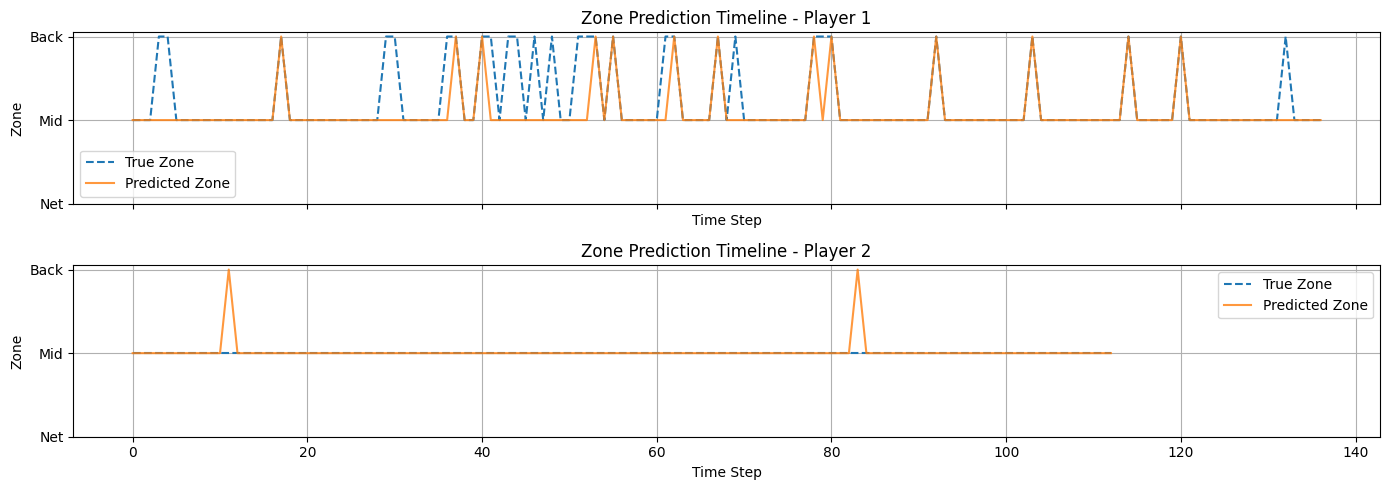

In [41]:
player_ids = np.array(player_ids)
# Train/Test Split (Also split player_ids)
X_train, X_val, y_train, y_val, pid_train, pid_val = train_test_split(
    X, y_cat, player_ids, test_size=0.2, random_state=42
)

# Predict
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)

# Per-Player Accuracy
print("\nPer-Player Accuracy:")
for player in ["Player 1", "Player 2"]:
    idx = pid_val == player
    acc = accuracy_score(y_val_true[idx], y_val_pred[idx])
    print(f"{player} → {acc * 100:.2f}%")

# Plot Zone Prediction Timeline Per Player
plot_save_path = "/content/drive/MyDrive/GraduateProject/per-player_accuracy.png"
fig, axes = plt.subplots(nrows=2, figsize=(14, 5), sharex=True)

for i, player in enumerate(["Player 1", "Player 2"]):
    ax = axes[i]
    idx = pid_val == player
    y_true_pid = y_val_true[idx]
    y_pred_pid = y_val_pred[idx]
    timesteps = np.arange(len(y_true_pid))

    ax.plot(timesteps, y_true_pid, label='True Zone', linestyle='--')
    ax.plot(timesteps, y_pred_pid, label='Predicted Zone', alpha=0.8)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(zone_labels)
    ax.set_title(f"Zone Prediction Timeline - {player}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Zone")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig(plot_save_path, dpi=300)
plt.show()

This graph visualizes the zone prediction performance over time for Player 1 and Player 2, showing how well the model predicted the player's next movement zone (Net, Mid, or Back).

The figure is split into two timelines:

* Top plot: Zone prediction timeline for Player 1

* Bottom plot: Zone prediction timeline for Player 2

Each plot compares:

* True Zone (dashed blue line)

* Predicted Zone (solid orange line)

**X-Axis:**
Time Steps — this is a sequence of frames or time intervals over the match where the model made a prediction.

**Y-Axis (Zone Labels)**
Each zone is encoded as:

0: Net

1: Mid

2: Back

**Insights by Player**

**Player 1 (Top Plot):**
* Zones alternate between Back and Mid, showing dynamic court coverage.

* The model captures transitions well, but occasional deviations (spikes into Mid when it was Back, or vice versa) are visible.

* These fluctuations might result from:

  * Short-term accelerations or decelerations.

  * Rapid lateral or diagonal movements that momentarily cross zone thresholds.


**Player 2 (Bottom Plot):**
* Very consistent behavior — the player remains almost entirely in the Mid zone throughout.

* Predicted and true zones are perfectly aligned, indicating:

* Strong model performance.

* Relatively static player movement (e.g., maintaining rally control or midcourt dominance).

**Model Performance:**

* Zone prediction accuracy is clearly visible.

* Player 1’s variability helps show model robustness.

* Player 2’s consistency shows that the model handles low-variance behavior just as effectively.

### Confusion matrix

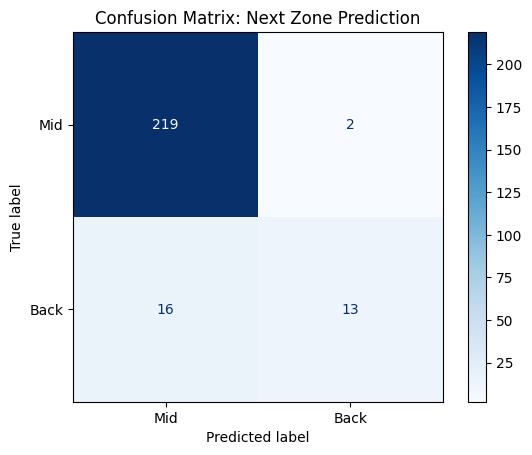

In [42]:
# Label definitions
zone_labels = ["Net", "Mid", "Back"]

# Get unique zone labels actually used
unique_labels = np.unique(np.concatenate([y_val_true, y_val_pred]))
display_labels = [zone_labels[i] for i in unique_labels]

# Compute and plot confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", values_format="d")

plt.title("Confusion Matrix: Next Zone Prediction")
plt.grid(False)
plt.show()

### Classification Report

In [43]:
y_true = y_val_true
y_pred_classes = y_val_pred

# Define label names
label_names = ["Net", "Mid", "Back"]

# Get only the labels present in the current prediction/ground truth
unique_labels = np.unique(np.concatenate([y_true, y_pred_classes]))

# Generate report
report = classification_report(
    y_true,
    y_pred_classes,
    labels=unique_labels,
    target_names=[label_names[i] for i in unique_labels],
    digits=2
)

print(" Classification Report:")
print(report)

# Save to file
report_path = "/content/drive/MyDrive/GraduateProject/classification_report.txt"
with open(report_path, "w") as f:
    f.write("Zone Prediction Report\n\n")
    f.write(report)

 Classification Report:
              precision    recall  f1-score   support

         Mid       0.93      0.99      0.96       221
        Back       0.87      0.45      0.59        29

    accuracy                           0.93       250
   macro avg       0.90      0.72      0.78       250
weighted avg       0.92      0.93      0.92       250



### Tactical Player Comparison

In [44]:
# Select Exactly Two Players (Assumed Already Merged)
player_ids = list(positions.keys())
player_A, player_B = player_ids[0], player_ids[1]

# Get Position and Metric Data
players = {
    player_A: positions[player_A],
    player_B: positions[player_B]
}
metrics = {
    player_A: metrics[player_A],
    player_B: metrics[player_B]
}

# Estimate Video Height Dynamically from Positions
video_height = max(y for pos_list in players.values() for _, y in pos_list)
net_threshold = video_height * 0.33

#  Define functions
def net_play_ratio(pid):
    if not players[pid]: return 0
    return sum(1 for _, y in players[pid] if y < net_threshold) / len(players[pid])

def total_distance(pid):
    return sum(metrics[pid]["distance"])

def explosiveness(pid):
    accel = metrics[pid]["acceleration"]
    return np.mean(np.abs(accel)) if len(accel) > 0 else 0

# Compute metrics
net_A = net_play_ratio(player_A)
net_B = net_play_ratio(player_B)

dist_A = total_distance(player_A)
dist_B = total_distance(player_B)

acc_A = explosiveness(player_A)
acc_B = explosiveness(player_B)

#  Tactical and Physical Comparison Report
print("\nTactical Player Comparison")

# Net Presence
print(f"Net Time: \nPlayer A (ID {player_A}): {net_A*100:.1f}% \nPlayer B (ID {player_B}): {net_B*100:.1f}%")
if net_A == net_B == 0:
    print("Net Dominator: None (Both players had no net activity)")
elif net_A == net_B:
    print("Net Dominator: None (Both players had equal net activity)")
else:
    print("Net Dominator:", "Player A" if net_A > net_B else "Player B")

# Ground Covered
print(f"\nGround Covered: \nPlayer A: {dist_A:.2f} m \nPlayer B: {dist_B:.2f} m")
if dist_A == dist_B:
    print("Covers More Ground: Equal ground coverage")
else:
    print("Covers More Ground:", "Player A" if dist_A > dist_B else "Player B")

# Explosiveness
print(f"\nExplosiveness: \nPlayer A: {acc_A:.2f} m/s² \nPlayer B: {acc_B:.2f} m/s²")
if acc_A == acc_B:
    print("More Explosive: Equal explosiveness")
else:
    print("More Explosive:", "Player A" if acc_A > acc_B else "Player B")


Tactical Player Comparison
Net Time: 
Player A (ID Player 1): 0.0% 
Player B (ID Player 2): 0.0%
Net Dominator: None (Both players had no net activity)

Ground Covered: 
Player A: 24.25 m 
Player B: 26.89 m
Covers More Ground: Player B

Explosiveness: 
Player A: 8.68 m/s² 
Player B: 9.60 m/s²
More Explosive: Player B


## Dashboard creation

In [45]:
# Config
dashboard_video_path = "/content/drive/MyDrive/GraduateProject/dashboard_analytics_video.mp4"
cap = cv2.VideoCapture(video_path)
out = cv2.VideoWriter(dashboard_video_path, fourcc, fps, (W, H))

# Buffers for smoothing real-time display
buffer_size = 5
speed_buffer = {"Player 1": deque(maxlen=buffer_size), "Player 2": deque(maxlen=buffer_size)}
accel_buffer = {"Player 1": deque(maxlen=buffer_size), "Player 2": deque(maxlen=buffer_size)}

# Summary metric functions
def net_play_ratio(player):
    if not positions[player]:
        return 0
    return sum(1 for _, y in positions[player] if y < H * 0.33) / len(positions[player])

def total_distance(player): return sum(metrics[player]["distance"])
def avg_speed(player): return np.mean(metrics[player]["speed"]) if metrics[player]["speed"] else 0
def max_speed(player): return np.max(metrics[player]["speed"]) if metrics[player]["speed"] else 0
def avg_acc(player): return np.mean(metrics[player]["acceleration"]) if metrics[player]["acceleration"] else 0
def max_acc(player): return np.max(metrics[player]["acceleration"]) if metrics[player]["acceleration"] else 0

summary_data = {
    player: {
        "total_distance": total_distance(player),
        "avg_speed": avg_speed(player),
        "max_speed": max_speed(player),
        "avg_acc": avg_acc(player),
        "max_acc": max_acc(player),
        "net_time": net_play_ratio(player) * 100
    }
    for player in ["Player 1", "Player 2"]
}
# Determine Leaders
net_dom = (
    "Player 1" if summary_data["Player 1"]["net_time"] > summary_data["Player 2"]["net_time"]
    else "Player 2" if summary_data["Player 2"]["net_time"] > summary_data["Player 1"]["net_time"]
    else "Equal"
)
exp_dom = (
    "Player 1" if summary_data["Player 1"]["avg_acc"] > summary_data["Player 2"]["avg_acc"]
    else "Player 2" if summary_data["Player 2"]["avg_acc"] > summary_data["Player 1"]["avg_acc"]
    else "Equal"
)
ground_dom = (
    "Player 1" if summary_data["Player 1"]["total_distance"] > summary_data["Player 2"]["total_distance"]
    else "Player 2" if summary_data["Player 2"]["total_distance"] > summary_data["Player 1"]["total_distance"]
    else "Equal"
)

# Real-time dashboard per-frame loop
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    tracked_ids = bounding_boxes_per_frame[frame_idx] if frame_idx < len(bounding_boxes_per_frame) else {}

    for tid, (x1, y1, x2, y2) in tracked_ids.items():
        player = id_map.get(tid)
        if player:
            if frame_idx < len(metrics[player]["speed"]):
                speed_buffer[player].append(metrics[player]["speed"][frame_idx])
            if frame_idx < len(metrics[player]["acceleration"]):
                accel_buffer[player].append(metrics[player]["acceleration"][frame_idx])

    speeds = {p: np.mean(speed_buffer[p]) if speed_buffer[p] else 0 for p in ["Player 1", "Player 2"]}
    accels = {p: np.mean(accel_buffer[p]) if accel_buffer[p] else 0 for p in ["Player 1", "Player 2"]}

    # Overlay Dashboard
    cv2.rectangle(frame, (10, 10), (W - 10, 90), (40, 40, 40), -1)
    cv2.putText(frame, "Real-Time Player Analytics", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    for i, player in enumerate(["Player 1", "Player 2"]):
        cv2.putText(frame,
                    f"{player} - Speed: {speeds[player]:.2f} m/s | Acc: {accels[player]:.2f} m/s^2",
                    (20, 55 + i * 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 255), 2)

    out.write(frame)
    frame_idx += 1

# === Final Summary Frame with Enhanced Readability ===
summary_frame = np.zeros((H, W, 3), dtype=np.uint8)
font = cv2.FONT_HERSHEY_SIMPLEX

# Font and layout settings
title_font_scale = 2.0
label_font_scale = 1.2
line_thickness = 2
left_x = 200
right_x = W // 2 + 100  # Shift closer to center
y_start = 200
y_gap = 50

# Title
cv2.putText(summary_frame, "FINAL MATCH SUMMARY", (W // 3 - 40, 60), font, title_font_scale, (255, 255, 255), 3)

# Player Stats
for i, player in enumerate(["Player 1", "Player 2"]):
    x = left_x if i == 0 else right_x
    d = summary_data[player]

    cv2.putText(summary_frame, f"{player}:", (x, y_start), font, 0.9, (255, 255, 255), 2)
    cv2.putText(summary_frame, f"Total Distance: {d['total_distance']:.2f} m", (x, y_start + 1 * y_gap), font, label_font_scale, (0, 255, 0), 2)
    cv2.putText(summary_frame, f"Average Speed: {d['avg_speed']:.2f} m/s", (x, y_start + 2 * y_gap), font, label_font_scale, (0, 255, 0), 2)
    cv2.putText(summary_frame, f"Max Speed: {d['max_speed']:.2f} m/s", (x, y_start + 3 * y_gap), font, label_font_scale, (0, 255, 0), 2)
    cv2.putText(summary_frame, f"Avg Acceleration: {d['avg_acc']:.2f} m/s^2", (x, y_start + 4 * y_gap), font, label_font_scale, (255, 150, 0), 2)
    cv2.putText(summary_frame, f"Max Acceleration: {d['max_acc']:.2f} m/s^2", (x, y_start + 5 * y_gap), font, label_font_scale, (255, 150, 0), 2)
    cv2.putText(summary_frame, f"Net Time: {d['net_time']:.2f}%", (x, y_start + 6 * y_gap), font, label_font_scale, (0, 255, 255), 2)

# Tactical Summary at Bottom Center
bottom_y = H - 400
cv2.putText(summary_frame, f"Net Dominator: {net_dom}", (W // 4, bottom_y), font, 1.2, (0, 255, 255), 2)
cv2.putText(summary_frame, f"Explosiveness Leader: {exp_dom}", (W // 4, bottom_y + 50), font, 1.2, (255, 100, 255), 2)
cv2.putText(summary_frame, f"Ground Coverage Leader: {ground_dom}", (W // 4, bottom_y + 100), font, 1.2, (100, 255, 255), 2)

# Hold for 2 seconds
for _ in range(fps * 2):
    out.write(summary_frame)


cap.release()
out.release()